In [ ]:
!pip install pyro-ppl

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
data = pd.read_csv('./ethusd_tweets.csv')

In [3]:
N = 360

highp = pd.to_numeric(data.ix[:, 'High'][-N:])
lowp = pd.to_numeric(data.ix[:, 'Low'][-N:])
openp = pd.to_numeric(data.ix[:, 'Open'][-N:])
closep = pd.to_numeric(data.ix[:, 'Close'][-N:])
tweets = pd.to_numeric(data.ix[:, 'Tweets'].replace('null', 0)[-N:])
volume = pd.to_numeric(data.ix[:, 'Volume'][-N:])
marketcap = pd.to_numeric(data.ix[:, 'Market_Cap'][-N:])

normal_close = closep

highp = highp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
lowp = lowp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
openp = openp.pct_change().replace(np.nan, 0).replace(np.inf, 0)
closep = closep.pct_change().replace(np.nan, 0).replace(np.inf, 0)
tweets = tweets.pct_change().replace(np.nan, 0).replace(np.inf, 0)
volume = volume.pct_change().replace(np.nan, 0).replace(np.inf, 0)
marketcap = marketcap.pct_change().replace(np.nan, 0).replace(np.inf, 0)

normal_close = np.array(normal_close)
highp = np.array(highp)
lowp = np.array(lowp)
openp = np.array(openp)
closep = np.array(closep)
tweets = np.array(tweets)
volume = np.array(volume)
marketcap = np.array(marketcap)

/home/chriamue/temp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/chriamue/temp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/home/chriamue/temp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/index

In [4]:
WINDOW = 7
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(openp), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volume[i:i+WINDOW]
        t = tweets[i:i+WINDOW]
        m = marketcap[i:i+WINDOW]
        
#         y_i = (normal_close[i+WINDOW+FORECAST] - normal_close[i+WINDOW]) / normal_close[i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]
        x_i = np.column_stack((o, h, l, c, v, t, m))
        x_i = x_i.flatten()

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)

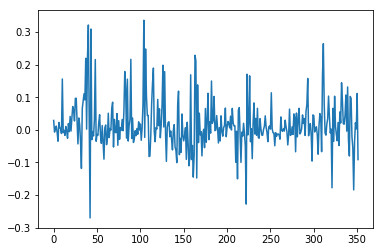

In [5]:
plt.figure()
plt.plot(Y)
plt.show()

In [6]:
print(X.shape, Y.shape)

(352, 49) (352,)


In [7]:
from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.layers import Input, concatenate
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

Using TensorFlow backend.


In [8]:
def get_model(input_size):
    main_input = Input(shape=(input_size, ), name='main_input')
    x = Dense(25, activation='linear')(main_input)
    output = Dense(1, activation = "linear", name = "out")(x)
    final_model = Model(inputs=[main_input], outputs=[output])
    final_model.compile(optimizer='adam',  loss='mse')
    return final_model

In [9]:
from sklearn.model_selection import TimeSeriesSplit

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=0.000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="testtest.hdf5", verbose=0, save_best_only=True)
    
X_train, Y_train = X[:-30], Y[:-30]
X_test, Y_test = X[-30:], Y[-30:]
    
model = get_model(len(X_train[0]))
history = model.fit(X_train, Y_train, 
              epochs = 100, 
              batch_size = 64, 
              verbose=1, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer],
              shuffle=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 322 samples, validate on 30 samples
Epoch 1/100
322/322 [==============================] - 0s 680us/step - loss: 0.2470 - val_loss: 0.1399
Epoch 2/100
322/322 [==============================] - 0s 10us/step - loss: 0.1751 - val_loss: 0.1176
Epoch 3/100
322/322 [==============================] - 0s 13us/step - loss: 0.1282 - val_loss: 0.1026
Epoch 4/100
322/322 [==============================] - 0s 13us/step - loss: 0.0926 - val_loss: 0.0874
Epoch 5/100
322/322 [==============================] - 0s 11us/step - loss: 0.0700 - val_loss: 0.0740
Epoch 6/100
322/322 [==============================] - 0s 12us/step - loss: 0.0526 - val_loss: 0.0619
Epoch 7/100
322/322 [==============================] - 0s 11us/step - loss: 0.0412 - val_loss: 0.0527
Epoch 8/100
322/322 [==============================] - 0s 11us/step - loss: 0.0333 - val_loss: 0.0444
Epoch 9/100
322/32

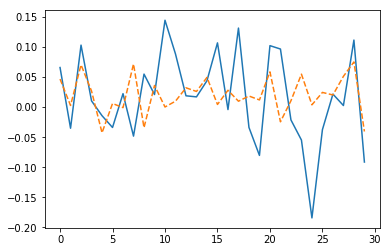

(322, 49) (30, 49) (322,) (30,)
0.006386014680429643
0.06405409859512454


In [10]:
model.load_weights('testtest.hdf5')
pred = model.predict(X_test)
predicted = pred
original = Y_test
plt.plot(original)
plt.plot(predicted, linestyle = '--')
plt.show()
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print(np.mean(np.square(predicted - original)))
print(np.mean(np.abs(predicted - original)))

In [11]:
import tensorflow as tf
sess = tf.Session()
with sess.as_default():
    tf.global_variables_initializer().run()

dense_weights, out_weights = None, None
with sess.as_default():
    for layer in model.layers:
        if len(layer.weights) > 0:
            weights = layer.get_weights()
            if 'dense' in layer.name:
                dense_weights = layer.weights[0].eval()
            if 'out' in layer.name:
                out_weights = layer.weights[0].eval()

In [12]:
print(dense_weights.shape)
print(out_weights.shape)

print(type(dense_weights))

(49, 25)
(25, 1)
<class 'numpy.ndarray'>


In [13]:
import torch
import torch.nn as nn
from torch.nn.functional import normalize  # noqa: F401
import torch.nn.functional as F

from torch.autograd import Variable

import pyro
from pyro.distributions import Normal, Bernoulli  # noqa: F401
from pyro.infer import SVI
from pyro.optim import Adam

pyro.get_param_store().clear()

In [14]:
print(X.shape, Y.shape)
X_train, Y_train = Variable(torch.Tensor(X[:-30])), Variable(torch.Tensor(Y[:-30]))
X_test, Y_test = Variable(torch.Tensor(X[-30:])), Variable(torch.Tensor(Y[-30:]))
print(X_train.shape, Y_train.shape)
data = torch.cat((X_train, Y_train.view(-1,1)), 1)

(352, 49) (352,)
torch.Size([322, 49]) torch.Size([322])


In [15]:
# get array of batch indices
def get_batch_indices(N, batch_size):
    all_batches = np.arange(0, N, batch_size)
    if all_batches[-1] != N:
        all_batches = list(all_batches) + [N]
    return all_batches

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, 1)   # output layer

    def forward(self, x):
        x = self.hidden(x)
        x = self.predict(x)
        return x

first_layer = len(X_train.data.numpy()[0])
second_layer = 25   
    
softplus = nn.Softplus()
regression_model = Net(first_layer, second_layer)

In [16]:
def model(data):

    mu = Variable(torch.zeros(second_layer, first_layer)).type_as(data)
    sigma = Variable(torch.ones(second_layer, first_layer)).type_as(data)
    bias_mu = Variable(torch.zeros(second_layer)).type_as(data)
    bias_sigma = Variable(torch.ones(second_layer)).type_as(data)
    w_prior, b_prior = Normal(mu, sigma), Normal(bias_mu, bias_sigma)
    
    mu2 = Variable(torch.zeros(1, second_layer)).type_as(data)
    sigma2 = Variable(torch.ones(1, second_layer)).type_as(data)
    bias_mu2 = Variable(torch.zeros(1)).type_as(data)
    bias_sigma2 = Variable(torch.ones(1)).type_as(data)
    w_prior2, b_prior2 = Normal(mu2, sigma2), Normal(bias_mu2, bias_sigma2)    
    
    priors = {'hidden.weight': w_prior, 
              'hidden.bias': b_prior,
              'predict.weight': w_prior2,
              'predict.bias': b_prior2}
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    with pyro.iarange("map", N, subsample=data):
        x_data = data[:, :-1]
        y_data = data[:, -1]
        # run the regressor forward conditioned on inputs
        prediction_mean = lifted_reg_model(x_data).squeeze()
        pyro.sample("obs",
                    Normal(prediction_mean, Variable(torch.ones(data.size(0))).type_as(data)),
                    obs=y_data.squeeze())
        

def guide(data):
    
    w_mu = Variable(torch.randn(second_layer, first_layer).type_as(data.data), requires_grad=True)
    w_log_sig = Variable(0.1 * torch.ones(second_layer, first_layer).type_as(data.data), requires_grad=True)
    b_mu = Variable(torch.randn(second_layer).type_as(data.data), requires_grad=True)
    b_log_sig = Variable(0.1 * torch.ones(second_layer).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_mu)
    sw_param = softplus(pyro.param("guide_log_sigma_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_mu)
    sb_param = softplus(pyro.param("guide_log_sigma_bias", b_log_sig))
    
    # gaussian guide distributions for w and b
    w_dist = Normal(mw_param, sw_param)
    b_dist = Normal(mb_param, sb_param)
    
    w_mu2 = Variable(torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    w_log_sig2 = Variable(0.1 * torch.randn(1, second_layer).type_as(data.data), requires_grad=True)
    b_mu2 = Variable(torch.randn(1).type_as(data.data), requires_grad=True)
    b_log_sig2 = Variable(0.1 * torch.ones(1).type_as(data.data), requires_grad=True)
    
    # register learnable params in the param store
    mw_param2 = pyro.param("guide_mean_weight2", w_mu2)
    sw_param2 = softplus(pyro.param("guide_log_sigma_weight2", w_log_sig2))
    mb_param2 = pyro.param("guide_mean_bias2", b_mu2)
    sb_param2 = softplus(pyro.param("guide_log_sigma_bias2", b_log_sig2))
    
    # gaussian guide distributions for w and b
    w_dist2 = Normal(mw_param2, sw_param2)
    b_dist2 = Normal(mb_param2, sb_param2)
      
    dists = {'hidden.weight': w_dist, 
              'hidden.bias': b_dist,
              'predict.weight': w_dist2,
              'predict.bias': b_dist2}
    
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", regression_model, dists)
    # sample a regressor
    return lifted_module()

In [17]:
# instantiate optim and inference objects
optim = Adam({"lr": 0.001})
loss_fn = pyro.infer.Trace_ELBO()
svi = SVI(model, guide, optim, loss=loss_fn)

N = len(X_train)

for j in range(3000):
    epoch_loss = 0.0
    perm = torch.randperm(N)
    # shuffle data
    data = data[perm]
    # get indices of each batch
    all_batches = get_batch_indices(N, 64)
    for ix, batch_start in enumerate(all_batches[:-1]):
        batch_end = all_batches[ix + 1]
        batch_data = data[batch_start: batch_end]        
        epoch_loss += svi.step(batch_data)
    if j % 100 == 0:
        print(j, "avg loss {}".format(epoch_loss/float(N)))

0 avg loss 493.7385399428584
100 avg loss 683.8481107683656
200 avg loss 279.7995487197956
300 avg loss 159.2576252579319
400 avg loss 218.08994124792747
500 avg loss 154.8846184734417
600 avg loss 103.97478690965575
700 avg loss 132.73746782022974
800 avg loss 83.84259578937329
900 avg loss 79.59258591814071
1000 avg loss 41.99082689755451
1100 avg loss 53.72317343394949
1200 avg loss 37.92214692712571
1300 avg loss 40.22636346195055
1400 avg loss 32.65494260228939
1500 avg loss 35.425351431651144
1600 avg loss 21.762261629659935
1700 avg loss 23.02925034302362
1800 avg loss 17.647394995881903
1900 avg loss 15.524177682325707
2000 avg loss 15.052892478726665
2100 avg loss 12.213593898907952
2200 avg loss 12.118854821468732
2300 avg loss 11.928496546626832
2400 avg loss 10.283452426794893
2500 avg loss 9.921730120729956
2600 avg loss 10.346476422888893
2700 avg loss 8.935867641653333
2800 avg loss 8.86618698642861
2900 avg loss 8.25728967193491


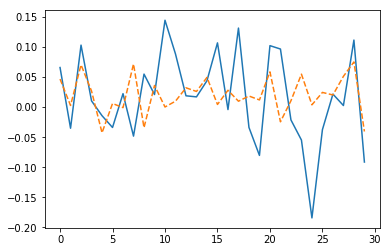

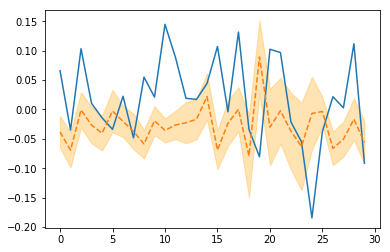

In [18]:
preds = []
for i in range(100):
    sampled_reg_model = guide(X_test)
    pred = sampled_reg_model(X_test).data.numpy().flatten()
    preds.append(pred)

preds = np.array(preds)
mean = np.mean(preds, axis=0)
std = np.std(preds, axis=0) / 10
y_test = Y_test.data.numpy()
x = np.arange(len(y_test))

plt.figure()
plt.plot(original)
plt.plot(predicted, linestyle = '--')
plt.show()

plt.figure()
plt.plot(x, y_test)
plt.plot(x, mean, linestyle = '--')
plt.fill_between(x, mean-std, mean+std, alpha = 0.3, color = 'orange')
plt.show()

In [19]:
for name in pyro.get_param_store().get_all_param_names():
    print(name, pyro.param(name).data.numpy())

guide_mean_weight [[ 5.3234592e-02  3.3809118e-02 -5.1784306e-04 ...  2.3266916e-01
   4.1178629e-01  2.3573915e-02]
 [-1.3171723e-02  3.6908682e-02 -2.1995449e-02 ...  3.7940356e-01
  -7.3498732e-01 -2.7079143e-02]
 [-6.7661046e-03 -3.5890963e-02  1.8793847e-02 ... -2.0982012e-01
  -9.9767536e-02 -3.7428443e-03]
 ...
 [ 6.4385189e-03  2.6486611e-02  5.4065540e-04 ...  7.0845522e-02
  -3.0232617e-01 -1.7693980e-02]
 [ 1.1140281e-02 -7.9761799e-03  2.5246451e-03 ...  3.3257537e-02
  -2.6363134e-01  2.3892913e-02]
 [-1.0944873e-02  5.0231513e-02 -1.3362796e-02 ... -8.6173058e-02
   1.7107596e-01  4.2567509e-03]]
guide_log_sigma_weight [[ 0.51764834  0.5782481   0.5261807  ...  0.0351722   0.41673124
   0.5165582 ]
 [ 0.49871048  0.562891    0.5105795  ... -0.20714122  0.24061774
   0.48769456]
 [ 0.5146938   0.532285    0.543429   ... -0.02738628  0.3677964
   0.49818888]
 ...
 [ 0.49866238  0.5222094   0.59354097 ... -0.05818425  0.1852276
   0.4999003 ]
 [ 0.5145364   0.49035534  0.524

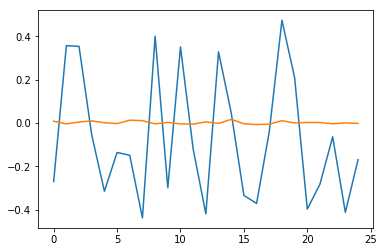

In [20]:
plt.figure()
plt.plot(out_weights)
plt.plot(pyro.param('guide_mean_weight2').data.numpy()[0])
plt.show()

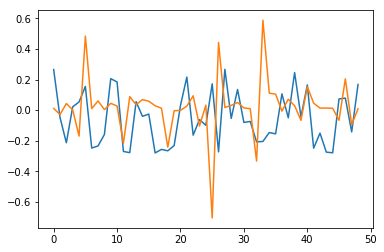

In [21]:
plt.figure()
plt.plot(dense_weights.T[14])
plt.plot(pyro.param('guide_mean_weight').data.numpy()[10])
plt.show()

In [24]:
print(out_weights.mean(), out_weights.std())
print(pyro.param('guide_mean_weight2').data.numpy()[0].mean(), pyro.param('guide_mean_weight2').data.numpy()[0].mean())

-0.070431136 0.29495174
0.0015008664 0.0015008664
